In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf

import os

from urllib2 import urlopen
import tarfile
import zipfile

# Image manipulation.
import PIL.Image
from IPython.display import Image, display

<!-- requirement: images/chipmunk.jpg -->

# DeepDream and the Inception Model

We can use deep learning to [create artwork](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html?m=1) as well. Using the [DeepDream](https://en.wikipedia.org/wiki/DeepDream) algorithm, we can modify images by amplifying the features detected by neural networks. We calculate the gradients in the model and then update the image accordingly. 

In this tutorial, we will use a pre-trained model called the Inception model. The Inception model has a very complicated architecture with many layers, and it takes weeks to train. You can read more about it in [this paper](https://arxiv.org/pdf/1512.00567v3.pdf). To create our artwork we will do the following:

1. Select a layer in the inception model
2. Feed the model an image
3. Calculate the gradient in the layer with respect to the image
4. Update the gradient to the image
5. Repeat 

### Download the Inception model

In [3]:
data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = "inception/5h/"
file_path = os.path.join(data_dir, 'inception5h')

if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

#download
f = urlopen(data_url) 
with open(file_path, "wb") as local_file:
            local_file.write(f.read())

#extract
zipfile.ZipFile(file=file_path, mode="r").extractall(data_dir)

### Get the graph

The graph has 12 layers, and we name them below.

In [4]:
#get graph
layer_names = ['conv2d0', 'conv2d1', 'conv2d2', 'mixed3a', 
               'mixed3b', 'mixed4a', 'mixed4b', 'mixed4c', 
               'mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']

graph = tf.Graph()
with graph.as_default():
    path = os.path.join(data_dir, "tensorflow_inception_graph.pb")
    with tf.gfile.FastGFile(path, 'rb') as file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())
        tf.import_graph_def(graph_def, name='')

graph_input = graph.get_tensor_by_name("input:0")
layer_tensors = [graph.get_tensor_by_name(name + ":0") for name in layer_names]

### Optimize the image using gradient ascent

In this step, we will calculate the gradient of the layer with respect to the image. We will average the square of the layer tensor to get a positive, scalar value for the tensor before differentiation. 

Then we will add the gradient to the image. When we repeat this process, we will amplify patterns in the image. 

In [5]:
def optimize(graph, graph_input, layer_tensor, image,
                   num_iterations=10, step_size=3.0):

    # Copy original image
    img = image.copy()
    img = img.astype(np.float32)

    # Calculate gradient
    gradient = tf.gradients(tf.reduce_mean(tf.square(layer_tensor)), graph_input)[0]

    for i in range(num_iterations):
        
        # Calculate the value of the gradient.
        feed_dict = {"input:0": np.expand_dims(img, axis=0)}
        grad = session.run(gradient, feed_dict=feed_dict)
        
        grad /= (np.std(grad) + 1e-8)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        grad = grad.reshape(img.shape)
        img += grad * step_size_scaled

    img = np.clip(img, 0.0, 255.0)
    img = img.astype(np.uint8) 
    return img

### Start session

In [6]:
session = tf.InteractiveSession(graph=graph)

### Load and plot image

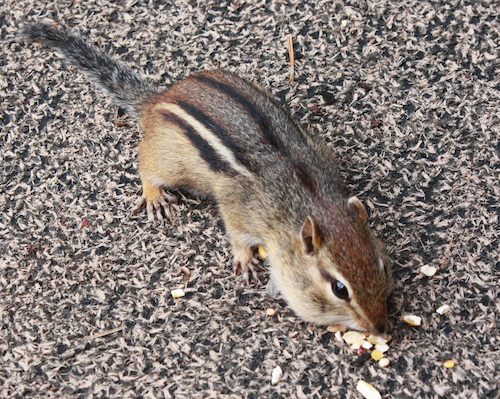

In [7]:
filename = './images/chipmunk.jpg'

image = np.float32(PIL.Image.open(filename))

# Ensure that image has rgb values between 0 and 225
image = np.clip(image, 0.0, 255.0)
        
# Convert pixels to bytes.
image = image.astype(np.uint8)

# Convert to a PIL-image and display it.
display(PIL.Image.fromarray(image))


### Choose a layer 

Choosing higher layers will result in higher-level feature or patterns. 

In [11]:
layer_tensor = layer_tensors[1]
layer_tensor

<tf.Tensor 'conv2d1:0' shape=(?, ?, ?, 64) dtype=float32>

### Make DeepDream image

In [12]:
mg_result = optimize(graph, graph_input, layer_tensor, image, num_iterations=10, step_size=6.0)

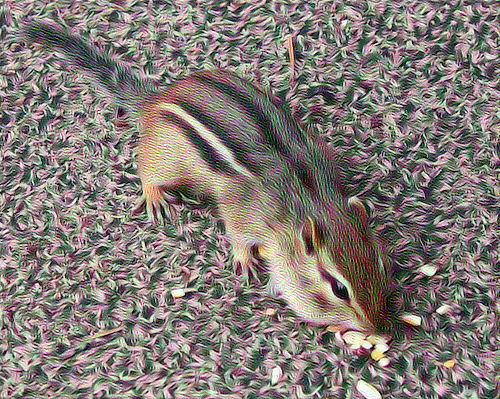

In [13]:
display(PIL.Image.fromarray(mg_result))

### Exercises: 

1. First play around with the layer number. The higher numbers correspond to more complex shapes that the model recognizes. 
2. Upload your own picture and perform the DeepDream algorithm on it. 
3. Don't square the tensor before you calculate the gradient. How does this change your results?

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*